# Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint, uniform
import shap
shap.initjs()

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings('ignore')

In [22]:
train_df = pd.read_csv('train_preprocessed.csv')
test_df = pd.read_csv('test_preprocessed.csv')
submission = pd.read_csv('sample_submission.csv')

# Modelling

In [3]:
# define X, y
X_train = train_df.drop(columns='NObeyesdad')
y_train = train_df['NObeyesdad']

X_test = test_df

In [4]:
# param_dist = {
#     'boosting_type': ['gbdt'],  
#     'metric': ['multi_logloss'],
#     'objective': ['multiclass'],
#     'num_leaves': np.arange(11, 200, 10),
#     'max_depth': np.arange(5, 30, 5),  
#     'learning_rate': uniform(0.01, 0.1),  
#     'n_estimators': np.arange(300, 500, 20),
#     'min_split_gain': np.arange(0, 1, 0.1),
#     'subsample': np.arange(0.5, 1.0, 0.1),  
#     'colsample_bytree': uniform(0.5, 0.5),  
#     'min_child_weight': np.arange(5, 40, 5),  
#     'reg_alpha': np.logspace(-4,2,7),  
#     'reg_lambda': np.logspace(-4,2,7)  
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# lgb = lgb.LGBMClassifier(random_state=42)

# gs_lgb = GridSearchCV(lgb, 
#                     param_grid=param_dist, 
#                     n_iter=100, 
#                     scoring='accuracy', 
#                     cv=cv, 
#                     n_jobs=-1, 
#                     random_state=42)

# gs_lgb.fit(X_train,y_train)

In [5]:
# gscv.best_params_

In [6]:
best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 300,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

In [7]:
train_acc = []
val_acc = []
precision = []
recall = []
f1 = []
roc_auc = []

# empty np arrays to store all labels and predictions
all_y_true = np.array([])
all_y_pred = np.array([])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    lgb_opt = lgb.LGBMClassifier(**best_params)
    lgb_opt.fit(X_train_fold, y_train_fold)

    # predict on training set
    y_train_pred = lgb_opt.predict(X_train_fold)
    y_train_pred_proba = lgb_opt.predict_proba(X_train_fold)
    # predict on val set
    y_val_pred = lgb_opt.predict(X_val_fold)
    y_val_pred_proba = lgb_opt.predict_proba(X_val_fold)

    # calculate metrics
    train_acc.append(accuracy_score(y_train_fold, y_train_pred))
    val_acc.append(accuracy_score(y_val_fold, y_val_pred))
    precision.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    recall.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    f1.append(f1_score(y_val_fold, y_val_pred, average='weighted'))
    roc_auc.append(roc_auc_score(y_val_fold, y_val_pred_proba, average='weighted', multi_class='ovr' ))
    
    # collect labels and predictions
    all_y_true = np.concatenate([all_y_true, y_val_fold])
    all_y_pred = np.concatenate([all_y_pred, y_val_pred])

# print training metrics
print(f"Train Accuracy: {np.mean(train_acc):.2f}")
print(f"Validation Accuracy: {np.mean(val_acc):.2f}")
print(f"Precision: {np.mean(precision):.2f}")
print(f"Recall: {np.mean(recall):.2f}")
print(f"F1 Score: {np.mean(f1):.2f}")
print(f"ROC AUC: {np.mean(roc_auc):.2f}")

# print classification report for all data collected from all folds
print(classification_report(all_y_true, all_y_pred, target_names=y_train.unique()))

Train Accuracy: 0.97
Validation Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
ROC AUC: 0.99
                     precision    recall  f1-score   support

Overweight_Level_II       0.93      0.94      0.93      2523
      Normal_Weight       0.88      0.89      0.88      3082
Insufficient_Weight       0.89      0.89      0.89      2910
   Obesity_Type_III       0.97      0.97      0.97      3248
    Obesity_Type_II       1.00      1.00      1.00      4046
 Overweight_Level_I       0.82      0.78      0.80      2427
     Obesity_Type_I       0.81      0.83      0.82      2522

           accuracy                           0.91     20758
          macro avg       0.90      0.90      0.90     20758
       weighted avg       0.91      0.91      0.91     20758



- Classes like Overweight_Level_II, Obesity_Type_II, Obesity_Type_III are well identified by the model, which is excellent for distinguishing severe cases
- Classes with lower precision and recall, such as Overweight_Level_I and Obesity_Type_I might benefit from more nuanced feature engineering or additional data samples to better define the boundaries between adjacent weight classes

Let's analyze the confusion matrix which can provice insights into specific misclassifications.

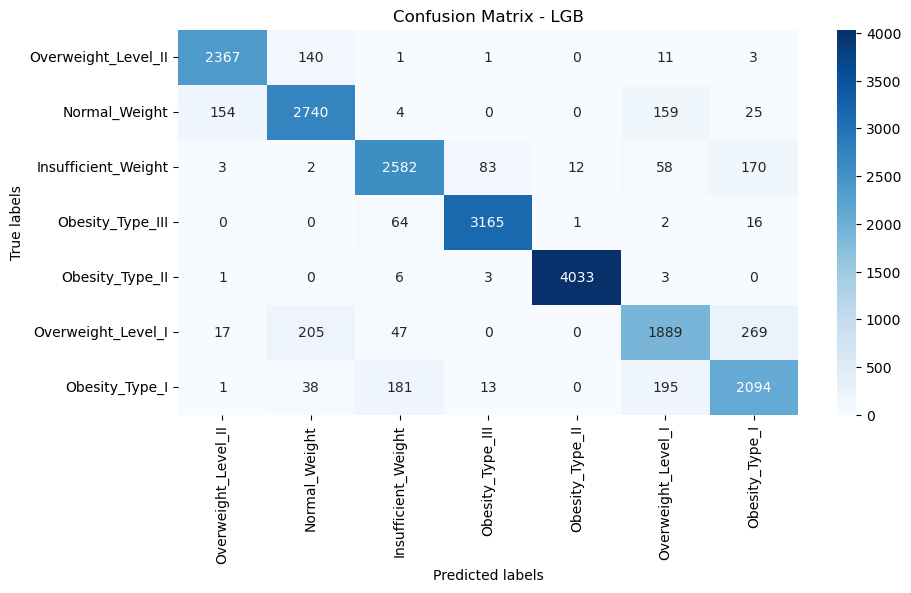

In [8]:
# plot the confusion matrix
cm_lgb = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm_lgb, annot=True, fmt='g', cmap='Blues', xticklabels=y_train.unique(), yticklabels=y_train.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - LGB')

plt.show()

- The model is highly effective at correctly classifying Obesity_Type_II and Obesity_Type_III, with very few misclassification, which suggests good separability in these classes
- Overweight_Level_I and Obesity_Type_I show relatively higher confusion with other classes. suggesting possible overlap in the feature space used to define these classes

# Feature Importance

In [19]:
# create the explainer object with the lgb model
explainer = shap.TreeExplainer(lgb_opt)

# calculate SHAP values 
shap_values = explainer.shap_values(X_train)

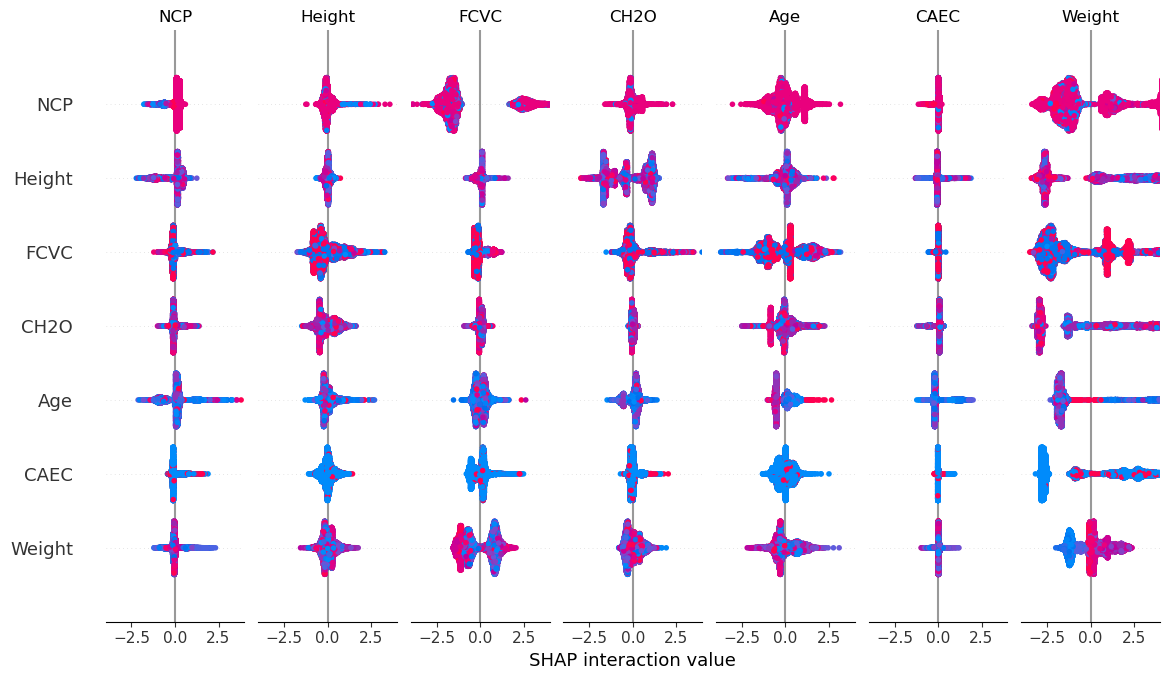

In [20]:
# plot summary plot
shap.summary_plot(shap_values, X_train)

# Predict on Test Set

In [23]:
submission.head()

,id,NObeyesdad
0,20758,Normal_Weight
1,20759,Normal_Weight
2,20760,Normal_Weight
3,20761,Normal_Weight
4,20762,Normal_Weight


In [28]:
# predict on X_test
predictions = lgb_opt.predict(X_test)

# put the predictions in the submission file
submission['NObeyesdad'] = predictions

# export the submission csv file
submission.to_csv('submission.csv', index=False)